[ **I ) Introduction**](#content1)

[ **II ) Data**](#content2)
- 2.1 Load & explore data
- 2.2 Split training and validation set

[ **III ) Transfer Learning model**](#content3)
- 3.1 About the optimizer and learning rate
- 3.2 VGG16
- 3.3 Data augmentation
- 3.4 Feature extraction
- 3.5 Plotting loss and accuracy - VGG16
- 3.6 Xception
- 3.7 Plotting loss and accuracy - Xception


[ **IV ) Conclusion **](#content5)

<a id="content1"></a>
## I) Introduction
Continuing after Project-1 where we did Flower Classification using the MobilenetV2, we now explore **VGG16** and **Xception** models for the same dataset and compare the performance of these models.

A network model that has been saved and earlier trained using a sizable dataset is known as a **pre-trained model.**

The concept behind **transfer learning** for image classification is that if we use a model that was trained on a really big, representative dataset, this model can serve as our basic model for categorising images. This allows to save a lot of training time by utilizing the feature maps.

**VGG16** - The VGG16 architecture consists of 16 layers, including 13 convolutional layers and 3 fully connected layers. The convolutional layers have small 3x3 filters and are followed by max-pooling layers. The number of filters in the convolutional layers increases as we move deeper into the network. The fully connected layers have 4096 neurons each and are followed by a softmax layer for classification. The model has more than 138 million parameters and is pre-trained on the ImageNet dataset, achieving top results in image classification and object detection tasks.

**Xception** - The Xception model consists of a total of 36 convolutional layers, which are organized into 14 modules. The first module is a standard convolutional layer followed by a max-pooling layer. The subsequent 13 modules follow a similar pattern of depthwise separable convolutional layers, where the depthwise convolution is followed by a pointwise convolution. The number of filters in the depthwise convolution increases in the middle layers and decreases in the final layers. The output of each module is then added to the previous output using a skip connection. The final layers include global average pooling, a fully connected layer, and a softmax layer for classification.

In [46]:
# import stuff 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from IPython.display import Image, display
import os
from keras.applications import xception
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import Model, optimizers
import tensorflow_hub as hub
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as prepro_res50
from tensorflow.keras.applications.vgg19 import preprocess_input as prepro_vgg19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, MaxPool2D, MaxPooling2D

In [3]:
# load the backend
from keras import backend as K

# prevent Tensorflow memory leakage
K.clear_session()

<a id="content2"></a>
## II) Data

### 2.1 - Load & explore data

In [4]:
path_data = r'D:\T431 - George Brown\DL Math 2\Flower_Classication_using_Transfer_Learning\flowers'
print(os.listdir(path_data))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [5]:
from os.path import join

img_folders = [join(path_data, folder) for folder in os.listdir(path_data)]
list(img_folders)

['D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\daisy',
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\dandelion',
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\rose',
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\sunflower',
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\tulip']

In [6]:
data_dir = r'D:\T431 - George Brown\DL Math 2\Flower_Classication_using_Transfer_Learning\flowers'

data = load_files(data_dir, random_state=28, shuffle=True)
X = np.array(data['filenames'])    # files location of each flower
y = np.array(data['target'])       # target label of each flower
labels = np.array(data['target_names'])

# remove eventual .pyc or .py files
pyc_file = (np.where(file==X) for file in X if file.endswith(('.pyc','.py')))
for pos in pyc_file:
    X = np.delete(X, pos)
    y = np.delete(y, pos)
    
print(f'Data files - {X}')
print(f'Target labels - {y}')   # numbers are corresponding to class label, 
                               # we have to change them to a vector of 5 elements
print(f'Name labels - {labels}')
print(f'Number of training files : {X.shape[0]}')

Data files - ['D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\rose\\2265390547_2409007cef_n.jpg'
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\dandelion\\34689593326_0fd3fbc38a_n.jpg'
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\tulip\\10094729603_eeca3f2cb6.jpg'
 ...
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\dandelion\\5598845098_13e8e9460f.jpg'
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\tulip\\5757091018_cdfd79dfa6_m.jpg'
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\dandelion\\34537877932_f9a3476a4d_n.jpg']
Target labels - [2 1 4 ... 1 4 1]
Name labels - ['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']
Number of training files : 4317


In [7]:
# Flower species number
df = pd.DataFrame({'species': y})
print(df.shape)
df.head()

(4317, 1)


species
0        2
1        1
2        4
3        2
4        4

In [8]:
# associate names to species number
df['flower'] = df['species'].astype('category')
df['flower'].cat.categories = labels
df.head()

C:\Users\pinku\AppData\Local\Temp\ipykernel_33048\1180994331.py:3: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  df['flower'].cat.categories = labels


species     flower
0        2       rose
1        1  dandelion
2        4      tulip
3        2       rose
4        4      tulip

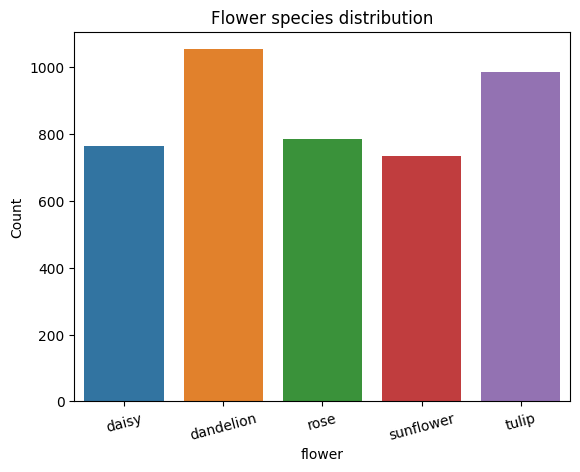

In [9]:
fig, ax = plt.subplots()
ax = sns.countplot(x="flower", data=df)
ax.set(ylabel='Count', title='Flower species distribution')
ax.tick_params(axis='x', rotation=15)

Now, we load the different images and transform them into numpy arrays

In [10]:
image_size = 224     # standard value for Transfer learning usecase (MobileNet, ResNet50, VGG16, VGG19)

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]   # load image
    img_array = np.array([img_to_array(img) for img in imgs])   # image to array 
    return(img_array)

X = np.array(read_and_prep_images(X))
print(X.shape)  # (4323, 224, 224, 3) = (num_images, height_size, width_size, depth=RGB)

(4317, 224, 224, 3)


Plotting some random flowers

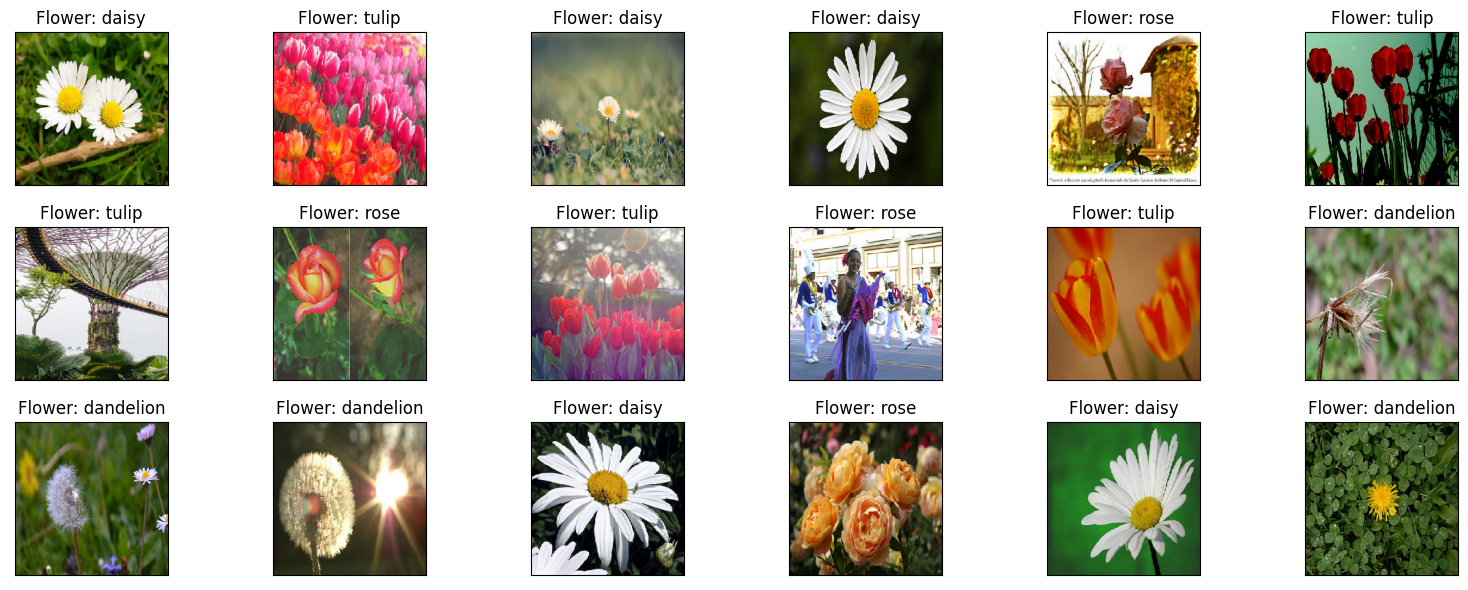

In [11]:
N = 18  # flowers to display
fig, axes = plt.subplots(3, 6, figsize=(16,6))
for ax, j in zip(axes.flat, np.random.randint(0, len(X), N)):    
    ax.imshow(X[j].astype(np.uint8))
    ax.set(title=f'Flower: {labels[y[j]]}', xticks=[], yticks=[])
fig.tight_layout()

### 2.2 - Label encoding

In [12]:
num_classes = len(np.unique(y))
print(f'Number of classes: {num_classes} --> {labels}')

Number of classes: 5 --> ['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']


Labels are the 5 species number (from 0 to 4). Thus, we need to encode these labels to one-hot vectors. For instance, an image of a sunflower should have a label 3 and a corresponding **y** = [0,0,0,1,0].

In [13]:
y = to_categorical(y, num_classes)
print(y.shape)

(4317, 5)


### 2.3 - Split training and validation set

Here, we're gonna split our dataset into a training, a validation and a testing one. This ensures that there are no bias: the model is trained on images with known labels, then we test our model accuracy on the validation dataset on images that our model did not see before. Finally, we compute the accuracy on the test dataset.

In [14]:
#train, validation and test from the train dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, 
                                                test_size=0.25, random_state=28)

Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5,
                                            shuffle=True, random_state=28)
print(f'Train dataset: {Xtrain.shape[0]}')
print(f'Validation dataset: {Xval.shape[0]}')
print(f'Test dataset: {Xtest.shape[0]}')

Train dataset: 3237
Validation dataset: 540
Test dataset: 540


In [15]:
#release memory
del X, y

<a id="content3"></a>
## III) Transfer Learning Models

### 3.1 About the optimizer and learning rate

When our model will be built, we need to specify an accuracy function, a loss function and an optimisation algorithm.

The accuracy function is used to evaluate the performance of the model.

The loss function is used to measure how the model performs on data with known labels. It tells us how poorly the model performs in a supersised system. For multi-label classification, we make use of a specific loss function called as *categorical_crossentropy* (similar to cross-entropy in maths).

Finally, the optimizer function is used in order to minize the loss function by changing model parameters (weighs values, filters kernel values etc.). 

For this classification problem, we choose the `RMSprop` optimizer which is very efficient and commonly used (more details on the [optimizers on Keras here](https://keras.io/optimizers/)).

Since deep networks can take quiet a time for the optimizer to converge, we're gonna use an annealing method of the learning rate (*LR*).

The *LR* is basically the step by which the optimizer is 'walking'. A hight *LR* correspond to big steps and thus the convergence is faster. However, in that case the sampling is not really efficient since the optimizer do not fall especially in the right minima.

At the opposite, have a low *LR* means that the optimizer will probably find the right local minima but it will take a lot of time. 

The idea here is to start from a low value but not so low and then decrease the *LR* along the training to reach efficiently the global minimum of the loss function. Using the `ReduceLROnPlateau` method , we are able to choose to reduce the *LR* by a coefficient (here 75%) if the accuracy has not improved after a number of epochs (here 3).

<br>

In addition, we use the `EarlyStopping` method to control the training time: if the accuracy has not improved after 5 epochs we stop.

Finally we make use of the `ModelCheckpoint` which is useful for monitoring the best found weights during the training.

### 3.2 Define the model - VGG16

In [19]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False)
x = vgg16_base_model.output
x = GlobalAveragePooling2D(name='globalaveragepooling2d')(x) # a global spatial average pooling layer
x = Dense(1024, activation='relu',name='fc1_Dense')(x)
x = Dropout(0.5, name='dropout_1')(x)
x = Dense(1024, activation='relu',name='fc2_Dense')(x)
x = Dropout(0.5, name='dropout_2')(x)
predictions = Dense(5, activation='softmax',name='output_layer')(x)
vgg16_model = Model(inputs=vgg16_base_model.input, outputs=predictions) # this is the model we will train


In [20]:
# frozen the first 15 layers
for layer in vgg16_model.layers[:15]:
    layer.trainable = False
for layer in vgg16_model.layers[15:]:
    layer.trainable = True

In [21]:
for i, layer in enumerate(vgg16_model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 globalaveragepooling2d True
20 fc1_Dense True
21 dropout_1 True
22 fc2_Dense True
23 dropout_2 True
24 output_layer True


In [22]:
# compile the model
sgd = SGD(lr=0.0001, momentum=0.9)
vgg16_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\pinku\anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 3.3 - Data augmentation

A useful trick to ovoid any overfitting is to use *data augmentation*. What is that? Well, the idea is to add artificially data into our dataset. But of course not any data, we alter the dataset with tiny transformations to reproduce very similar images. 

For instance, we rotate of a few degree an image, we de-center it or we zoom in or out a little bit. These common augmentation techniques are horizontal/vertical flips, rotations, translations, rescaling, random crops, adjust brightness and more.

Thanks to these transformations, we can get bigger dataset (x2, x3 in size) and then train our model in a much robust way.

In [23]:
image_size = 224
batch_size = 32
path = r'flowers'

#train_gen = train_aug.flow(Xtrain, ytrain, batch_size=batch_size)
# The validation data must not have data augmentation
#valid_gen = valid_no_aug.flow(Xval, yval, batch_size=batch_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,           # rescale pixel values [0,255] to [0,1]
        horizontal_flip=True,     # random horizontal flip
        width_shift_range=0.2,    # random shift images horizontally (fraction of total width)
        height_shift_range=0.2,   # random shift images vertically (fraction of total height)
        zoom_range=0.2)           # random zoom image
        #rotation_range=20,       # random rotation
        #shear_range=0.2)         # shear transfo
        #validation_split=0.2)    # splitting train / test datasets

test_datagen = ImageDataGenerator(
        rescale=1./255)
        #validation_split=0.2)

train_gen = train_datagen.flow(
        Xtrain, ytrain, 
        batch_size=batch_size,
        shuffle=False)              # already applied

valid_gen = test_datagen.flow(
        Xval, yval,
        batch_size=batch_size,
        shuffle=False)  

In [25]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 3.4 Feature extraction

In [26]:
batch_size = 32
epochs_0 = 40
steps_per_epoch = len(train_gen.x) // train_gen.batch_size
validation_steps = len(valid_gen.x) // valid_gen.batch_size

history = vgg16_model.fit(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=epochs_0 ,
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size)

Epoch 1/40
101/101 [==============================] - 108s 879ms/step - loss: 1.6768 - accuracy: 0.2197 - val_loss: 1.5606 - val_accuracy: 0.3105
Epoch 2/40
101/101 [==============================] - 83s 816ms/step - loss: 1.6241 - accuracy: 0.2465 - val_loss: 1.5199 - val_accuracy: 0.3828
Epoch 3/40
101/101 [==============================] - 84s 830ms/step - loss: 1.5839 - accuracy: 0.2914 - val_loss: 1.4697 - val_accuracy: 0.4414
Epoch 4/40
101/101 [==============================] - 85s 844ms/step - loss: 1.5390 - accuracy: 0.3267 - val_loss: 1.4073 - val_accuracy: 0.4219
Epoch 5/40
101/101 [==============================] - 45s 436ms/step - loss: 1.4804 - accuracy: 0.3719 - val_loss: 1.3277 - val_accuracy: 0.4805
Epoch 6/40
101/101 [==============================] - 42s 417ms/step - loss: 1.4097 - accuracy: 0.4181 - val_loss: 1.2385 - val_accuracy: 0.5215
Epoch 7/40
101/101 [==============================] - 47s 467ms/step - loss: 1.3374 - accuracy: 0.4443 - val_loss: 1.1554 - val_a

In [27]:
# Generator for test dataset
vgg16_datagen = ImageDataGenerator(
        rescale=1./255)

eval_datagen = vgg16_datagen.flow(
        Xtest, ytest,
        batch_size=batch_size,
        shuffle=False)      # since shuffle was already during splitting into train, valid, test

# Evaluation on the test dataset
loss, acc = vgg16_model.evaluate(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

Test loss: 0.44
Test accuracy: 85.00%


### 3.5 Plotting Accuracy and Loss - VGG16

In [28]:
def plot_history(history, loss_max=5):
    """
    Check loss and accuracy evolution.
    """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', 
            ylim=([min(plt.ylim()),1]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

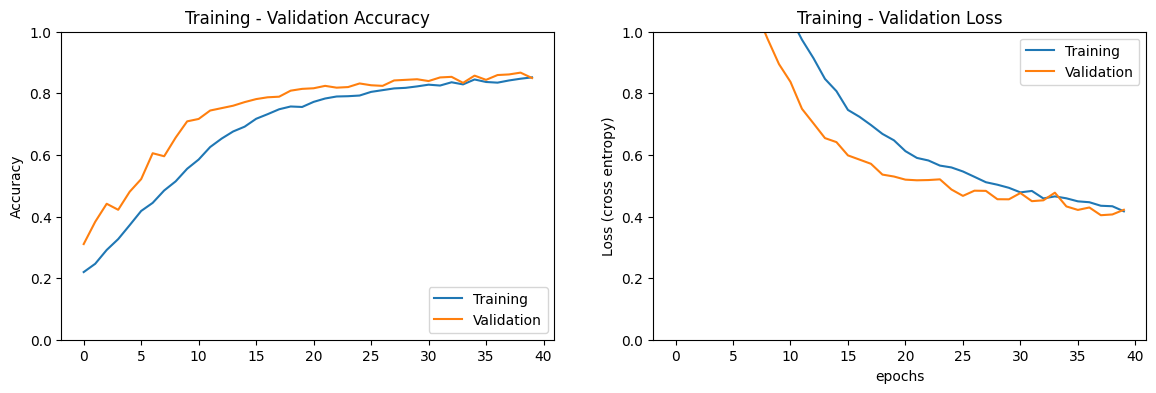

In [29]:
plot_history(history, loss_max=1)

17/17 [==============================] - 4s 208ms/step
              precision    recall  f1-score   support

           0       0.93      0.81      0.86        99
           1       0.88      0.91      0.89       128
           2       0.74      0.91      0.81        99
           3       0.87      0.88      0.87        88
           4       0.86      0.76      0.81       126

    accuracy                           0.85       540
   macro avg       0.86      0.85      0.85       540
weighted avg       0.86      0.85      0.85       540



Text(0.5, 36.72222222222221, 'Predicted label')

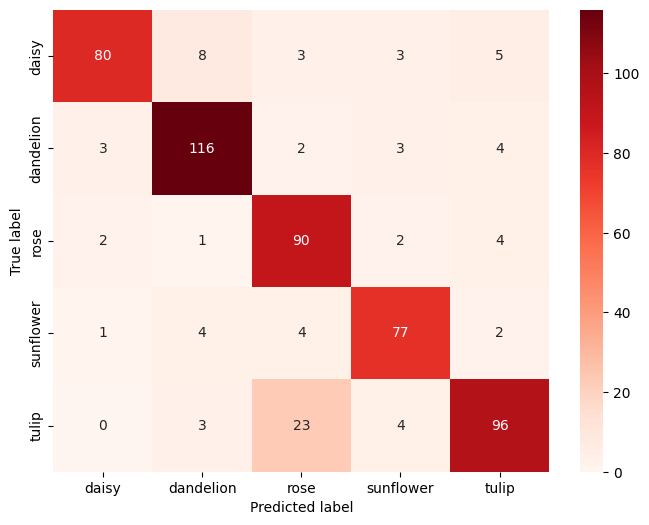

In [30]:
import seaborn as sns
from sklearn import metrics

pred = vgg16_model.predict(eval_datagen, verbose=1)

# get most likely class
y_pred = pred.argmax(axis=1)
y_true = ytest.argmax(axis=1)

print(metrics.classification_report(y_true, y_pred))

# confusion matrix
mat = metrics.confusion_matrix(y_true, y_pred)
df_mat = pd.DataFrame(mat, index=labels, columns=labels)
plt.figure(figsize=(8,6))
sns.heatmap(df_mat, annot=True, fmt='d', cmap=plt.cm.Reds)
#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 0.98, 'Predicted flowers; Incorrect Labels in Red')

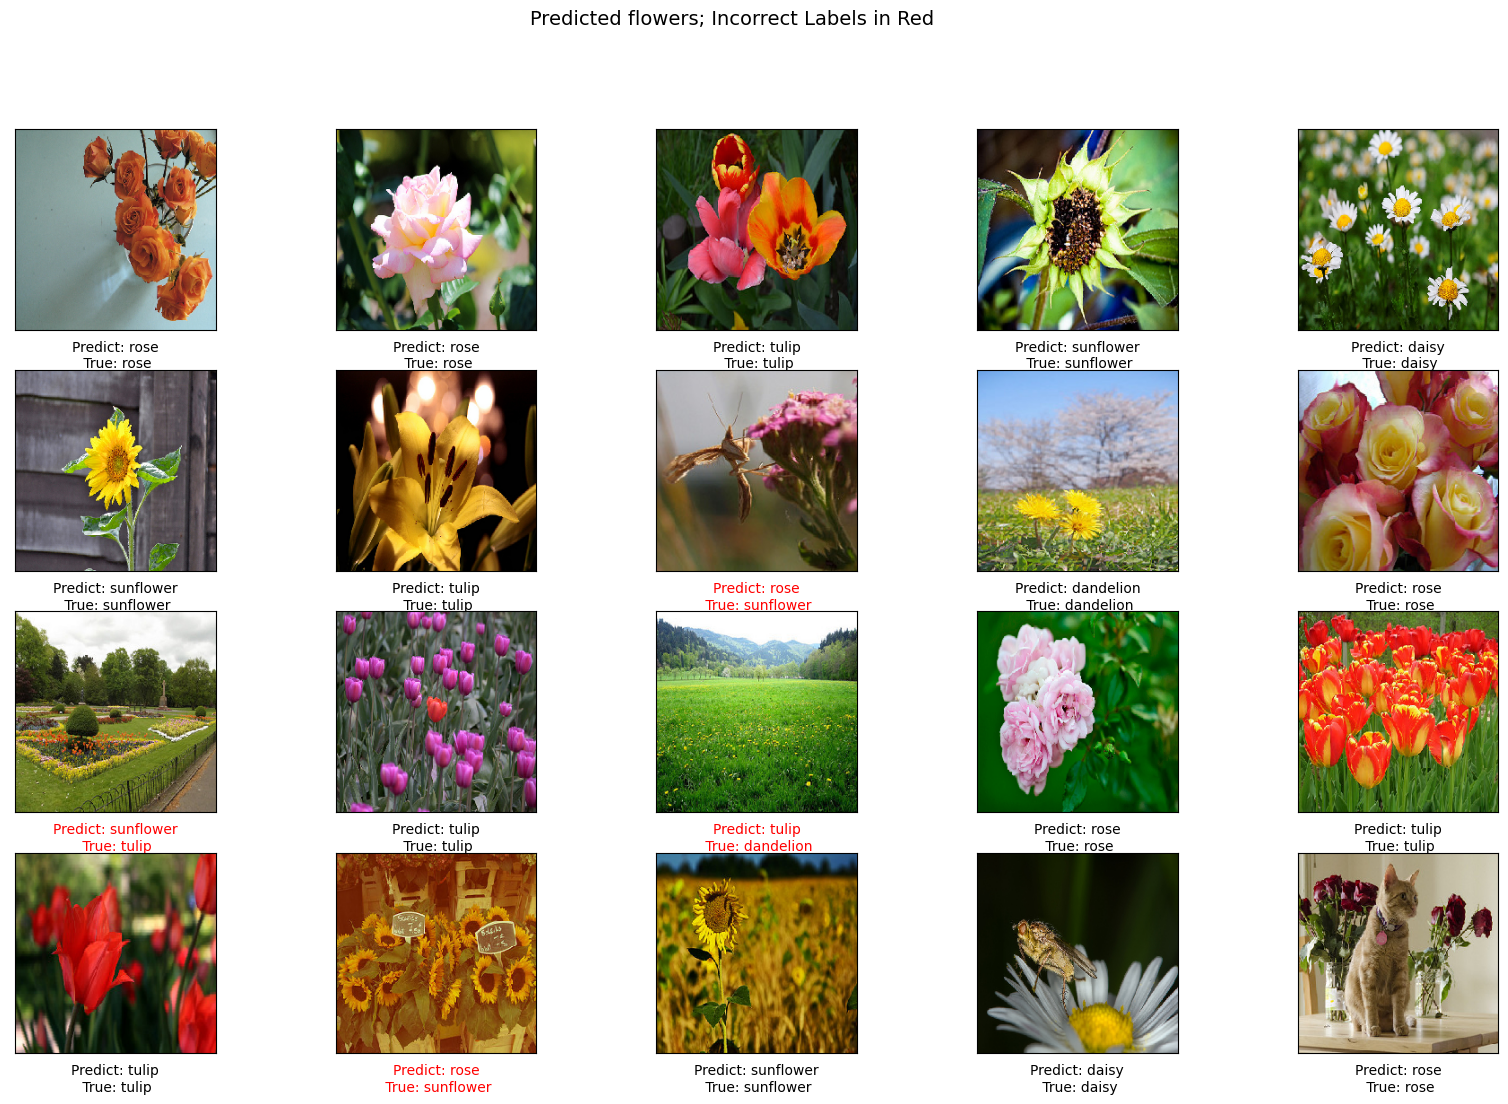

In [31]:
N = 20  # flowers to display
fig, axes = plt.subplots(4, 5, figsize=(20,12))
for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].astype(np.uint8))
    ax.set(xticks=[], yticks=[])
    true = y_true[i]
    prediction = y_pred[i]   
    ax.set_xlabel(f'Predict: {labels[prediction]}\n True: {labels[true]}', 
                  color='black' if true == prediction else 'red')

#fig.tight_layout()
fig.suptitle('Predicted flowers; Incorrect Labels in Red', size=14)

### 3.6 Define the model - Xception

In [40]:

# Import the Xception model to use as the base for our model
xception_base = xception.Xception(
    include_top=False,
    weights='imagenet'
)
x = xception_base.output

    # Global averaging pool layer
x = GlobalAveragePooling2D()(x)

    # Regular densely connected layer
x = Dense(512, activation='relu')(x)

    # Output layer
predictions = Dense(5, activation='softmax')(x)

xception_model = Model(inputs=xception_base.input, outputs=predictions)

In [47]:
def setup_model(model, trainable):
    # Freeze the un-trainable layers of the model base
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss='categorical_crossentropy',
        # Slower training rate for fine-tuning
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
        metrics=['accuracy']
    )


In [48]:
setup_model(xception_model, 19)

c:\Users\pinku\anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [49]:
for i, layer in enumerate(xception_model.layers):
   print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [50]:
xception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                         

In [51]:
batch_size = 32
epochs_0 = 40
steps_per_epoch = len(train_gen.x) // train_gen.batch_size
validation_steps = len(valid_gen.x) // valid_gen.batch_size

history_2 = xception_model.fit(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=epochs_0 ,
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size)


Epoch 1/40
101/101 [==============================] - 38s 337ms/step - loss: 1.6074 - accuracy: 0.2477 - val_loss: 1.5291 - val_accuracy: 0.3672
Epoch 2/40
101/101 [==============================] - 32s 312ms/step - loss: 1.5303 - accuracy: 0.3850 - val_loss: 1.4275 - val_accuracy: 0.4707
Epoch 3/40
101/101 [==============================] - 31s 311ms/step - loss: 1.4612 - accuracy: 0.4949 - val_loss: 1.3546 - val_accuracy: 0.5488
Epoch 4/40
101/101 [==============================] - 32s 313ms/step - loss: 1.3992 - accuracy: 0.5304 - val_loss: 1.3048 - val_accuracy: 0.5996
Epoch 5/40
101/101 [==============================] - 32s 315ms/step - loss: 1.3404 - accuracy: 0.5676 - val_loss: 1.2570 - val_accuracy: 0.6367
Epoch 6/40
101/101 [==============================] - 32s 314ms/step - loss: 1.2798 - accuracy: 0.6066 - val_loss: 1.2002 - val_accuracy: 0.6543
Epoch 7/40
101/101 [==============================] - 32s 315ms/step - loss: 1.2202 - accuracy: 0.6427 - val_loss: 1.1447 - val_ac

In [52]:
xception_datagen = ImageDataGenerator(
        rescale=1./255)

eval_datagen = xception_datagen.flow(
        Xtest, ytest,
        batch_size=batch_size,
        shuffle=False)      # since shuffle was already during splitting into train, valid, test

# Evaluation on the test dataset
loss, acc = xception_model.evaluate(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

Test loss: 0.42
Test accuracy: 84.26%


### 3.7 Plotting Accuracy and Loss - Xception

In [53]:
def plot_history(history, loss_max=5):
    """
    Check loss and accuracy evolution.
    """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', 
            ylim=([min(plt.ylim()),1]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

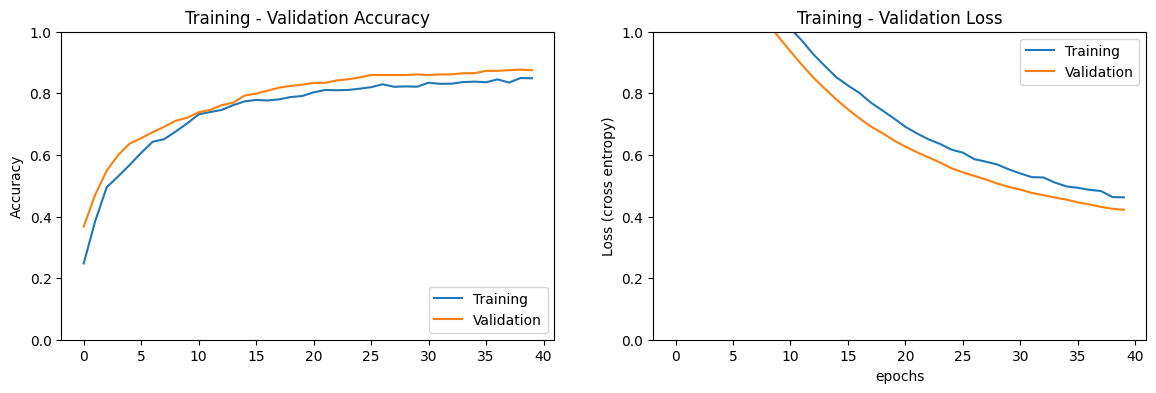

In [54]:
plot_history(history_2, loss_max=1)

17/17 [==============================] - 3s 120ms/step
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        99
           1       0.86      0.90      0.88       128
           2       0.79      0.84      0.81        99
           3       0.88      0.80      0.83        88
           4       0.82      0.84      0.83       126

    accuracy                           0.84       540
   macro avg       0.85      0.84      0.84       540
weighted avg       0.84      0.84      0.84       540



Text(0.5, 36.72222222222221, 'Predicted label')

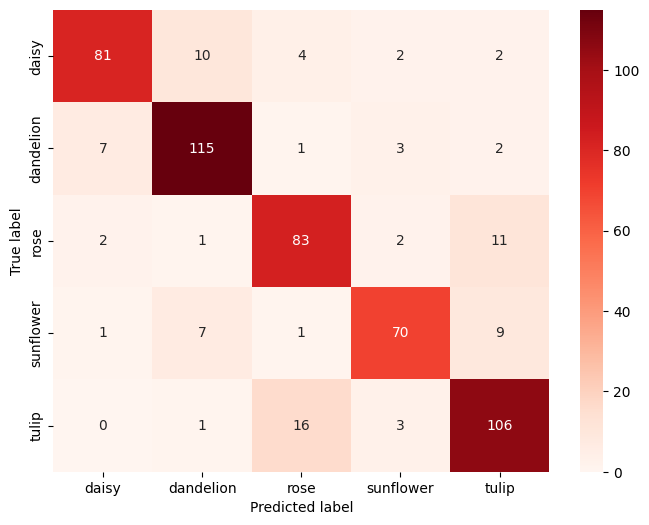

In [55]:
import seaborn as sns
from sklearn import metrics

pred = xception_model.predict(eval_datagen, verbose=1)

# get most likely class
y_pred = pred.argmax(axis=1)
y_true = ytest.argmax(axis=1)

print(metrics.classification_report(y_true, y_pred))

# confusion matrix
mat = metrics.confusion_matrix(y_true, y_pred)
df_mat = pd.DataFrame(mat, index=labels, columns=labels)
plt.figure(figsize=(8,6))
sns.heatmap(df_mat, annot=True, fmt='d', cmap=plt.cm.Reds)
#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 0.98, 'Predicted flowers; Incorrect Labels in Red')

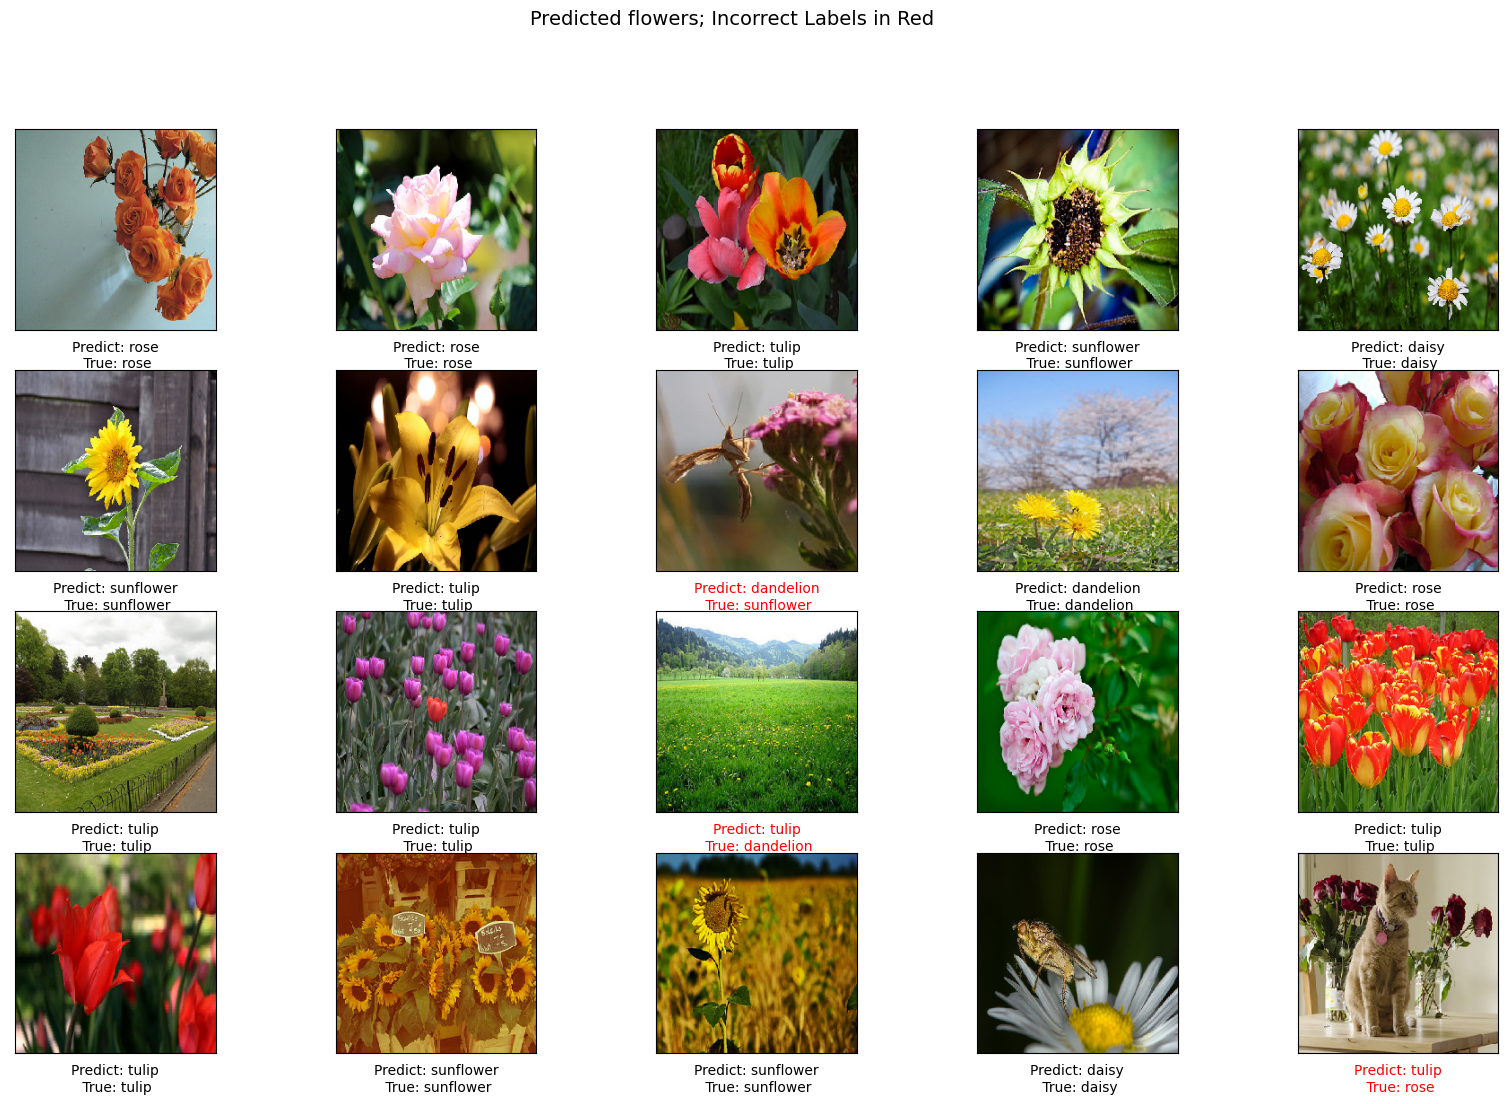

In [56]:
N = 20  # flowers to display
fig, axes = plt.subplots(4, 5, figsize=(20,12))
for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].astype(np.uint8))
    ax.set(xticks=[], yticks=[])
    true = y_true[i]
    prediction = y_pred[i]   
    ax.set_xlabel(f'Predict: {labels[prediction]}\n True: {labels[true]}', 
                  color='black' if true == prediction else 'red')

#fig.tight_layout()
fig.suptitle('Predicted flowers; Incorrect Labels in Red', size=14)

<a id="content5"></a>
## Conclusion

In conclusion, we trained VGG16 and Xception models on a flower classification dataset and achieved high accuracy levels on both models. The VGG16 model achieved a test accuracy of **85%**, while the Xception model achieved a slightly lower test accuracy of **84.26%**. However, the Xception model had a higher validation accuracy of **87.50%** compared to VGG16's **84.98%**. Both models had similar training accuracies, with VGG16 at **85.18%** and Xception at **84.90%**. Based on these results, it can be concluded that both models performed well on the flower classification task, but the Xception model may have a slight advantage in terms of generalization performance. Further experimentation and evaluation can be done to explore the strengths and weaknesses of each model in more detail.



